# Rho Pre-processing
The purpose of this notebook is to separate the histograms, normalization, and any additional data processing and investigation
from the main noteboks. This way the PointNet.ipynb notebooks are free of anything other than training, such that de-bugging
and creating custom training loops (if necessary) is possible.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
import scipy.constants as spc

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

plotpath = '/home/russbate/MLPionCollaboration/LCStudies/segmentation/Plots/October/'

## Load Data
#### X = [Energy, Eta, Phi, rPerp]
#### Y = [EM Energy, non EM Energy]

In [14]:
t0 = t.time()
Xraw = np.load('/data/atlas/rbate/Rho_X_4_files.npy', mmap_mode='r')[:,:,:]
Yraw = np.load('/data/atlas/rbate/Rho_Y_4_files.npy', mmap_mode='r')[:,:,:]
print(Xraw.shape)
print(Yraw.shape)

X = np.lib.format.open_memmap('/data/atlas/rbate/XR_Rho_Pre-Processing.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], Xraw.shape[2]))
np.copyto(dst=X, src=Xraw[:,:,:], casting='same_kind', where=True)

Y = np.lib.format.open_memmap('/data/atlas/rbate/YR_Rho_Pre-Processing.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0], Yraw.shape[1], Yraw.shape[2]))
np.copyto(dst=Y, src=Yraw[:,:,:], casting='same_kind', where=True)
t1 = t.time()
print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

(2550, 1078, 4)
(2550, 1078, 2)
Time to load memory mapped data: 2.4704647064208984 (s)


### Show EM/nonEM Targets

In [15]:
# Cell mask is used throughout notebook to show which nonzero points to use
## Cell mask is non zero points of INPUT data
eta_mask = Xraw[:,:,1] != 0
phi_mask = Xraw[:,:,2] != 0
rPerp_mask = Xraw[:,:,3] != 0
cell_mask = np.logical_or(eta_mask, phi_mask, rPerp_mask)

# Create masks for plots etc.
E_mask = Xraw[:,:,0] != 0
Energies = np.ndarray.copy(Xraw[:,:,0])

Energy_EM = np.ndarray.copy(Yraw[:,:,0])
Energy_nonEM = np.ndarray.copy(Yraw[:,:,1])

# this is a non zero mask for the truth elements. This it turns out is different
# than the input data
nz_mask = (Energy_EM + Energy_nonEM) != 0
ratio = np.zeros(nz_mask.shape)
ratio[nz_mask] = Energy_nonEM[nz_mask] / (Energy_EM[nz_mask]+Energy_nonEM[nz_mask])

#### Check if the truth targets match the input dataprint(ratio.shape)

In [16]:
print(ratio.shape)
print(np.array_equal(nz_mask, cell_mask))
''' what this means is that where all the cells are, there exist ratios that are going to add to zero,
perhaps this means there is noise. i.e. the calorimeter is picking up signals where there is nothing
in the truth array. '''

(2550, 1078)
False


' what this means is that where all the cells are, there exist ratios that are going to add to zero,\nperhaps this means there is noise. i.e. the calorimeter is picking up signals where there is nothing\nin the truth array. '

#### Histogram of all cell energy

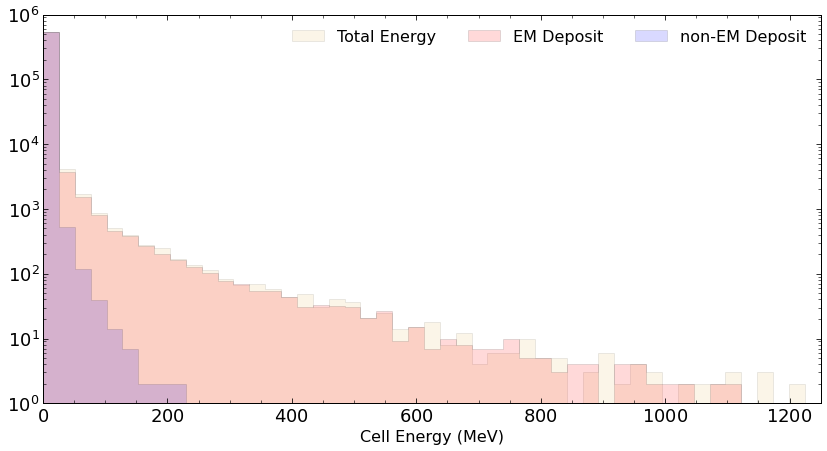

In [17]:
fig = plt.figure(figsize=(12,6))

Bins = np.linspace(0,1250,50,endpoint=True)
hist_mask = Energies != 0
ax1 = fig.add_axes([.05,.05,.9,.9])
ax1.hist(Energies[hist_mask], bins=Bins, color='goldenrod', edgecolor='black', alpha=.10, linewidth=.75,
        histtype='stepfilled', label='Total Energy')
ax1.hist(Energy_EM[hist_mask], bins=Bins, color='red', edgecolor='black', alpha=.15, linewidth=.75,
        histtype='stepfilled', label='EM Deposit')
ax1.hist(Energy_nonEM[hist_mask], bins=Bins, color='blue', edgecolor='black', alpha=.15, linewidth=.75,
        histtype='stepfilled', label='non-EM Deposit')
ax1.set_yscale('log')
ax1.set_xlim(0,1250)
ax1.set_ylim(1,1e6)
ax1.set_xlabel('Cell Energy (MeV)', fontsize=16)
ax1.legend(loc='upper right', ncol=3, prop={'size':16})

# plt.savefig(plotpath+'Energy_distribution_cells.png', format='png')
plt.show()

#### Histogram of Energy Ratio

<Figure size 799.992x599.976 with 0 Axes>

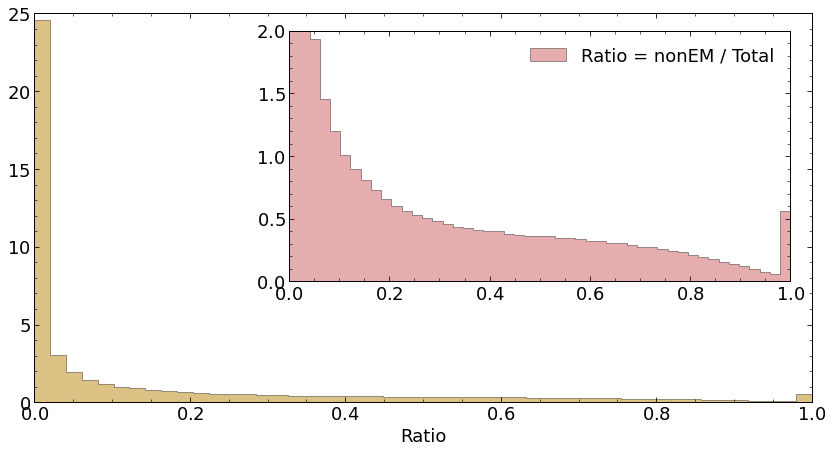

In [18]:
plt.cla();plt.clf()

fig = plt.figure(figsize=(12,6))

Bins = np.linspace(0,1,50,endpoint=True)

ax1 = fig.add_axes([.05,.05,.9,.9])
ax1.hist(ratio[nz_mask], bins=Bins, color='darkgoldenrod', edgecolor='black', alpha=.50, linewidth=.75,
        histtype='stepfilled', label=None, density=True)
ax1.set_xlim(0,1)
ax1.set_ylim(0,25)

ax2 = fig.add_axes([.345,.33,.58,.58])
ax2.hist(ratio[nz_mask], bins=Bins, color='indianred', edgecolor='black', alpha=.50, linewidth=.75,
        histtype='stepfilled',label='Ratio = nonEM / Total', density=True)
ax2.set_ylim(0,2)
ax2.set_xlim(0,1)
ax2.legend(loc='upper right', ncol=1, prop={'size':18})

ax1.set_xlabel('Ratio', fontsize=18)

# plt.savefig(plotpath+'Energy_ratio_cells.png', format='png')
plt.show()

#### Create Categorization Labels
Note this can be done with numpy 'one hot' encoding but this is done manually here

In [19]:
EM = np.full(nz_mask.shape, np.nan)
nonEM = np.full(nz_mask.shape, np.nan)
target_ratio = np.full((nz_mask.shape), np.nan)

EM[nz_mask] = np.ndarray.copy(Yraw[nz_mask,0])
nonEM[nz_mask] = np.ndarray.copy(Yraw[nz_mask,1])

target_labels = np.full((nz_mask.shape[0],nz_mask.shape[1],3), 0)
target_ratio[nz_mask] = EM[nz_mask] / (EM[nz_mask] + nonEM[nz_mask])

em_mask = target_ratio > .8
nonem_mask = target_ratio < .2
mix_mask = np.invert(np.logical_or(em_mask, nonem_mask))

target_labels[em_mask,0] = 1
target_labels[mix_mask,1] = 1
target_labels[nonem_mask,2] = 1

print('Number EM: '+str(np.count_nonzero(em_mask)))
print('Number NON-EM: '+str(np.count_nonzero(nonem_mask)))
print('Number MIX: '+str(np.count_nonzero(mix_mask)))

# change the pointer for Y to the target labels
Y = target_labels

Number EM: 389638
Number NON-EM: 18871
Number MIX: 2340391


#### Troubleshooting step:
 - [x] Make sure that target ratio has no nan values
 - [ ] make sure that the X array is using the nz_mask so there are no mis-matches

In [20]:
print(np.any(target_labels == np.nan))

False


## Point Normalization
 - [x] Convert to x,y,z
 - [x] Investigate Inputs (Rho_Pre-processing.ipynb)

In [21]:
t0 = t.time()
print(cell_mask.shape)
print(X[cell_mask, :3].shape)
X[nz_mask, 1:4] = dsu.to_xyz(X[nz_mask, 1:4])
t1 = t.time()
print('Time to convert to xyz: '+str(t1-t0)+' (s)')

(2550, 1078)
(537020, 3)
Time to convert to xyz: 0.5879967212677002 (s)


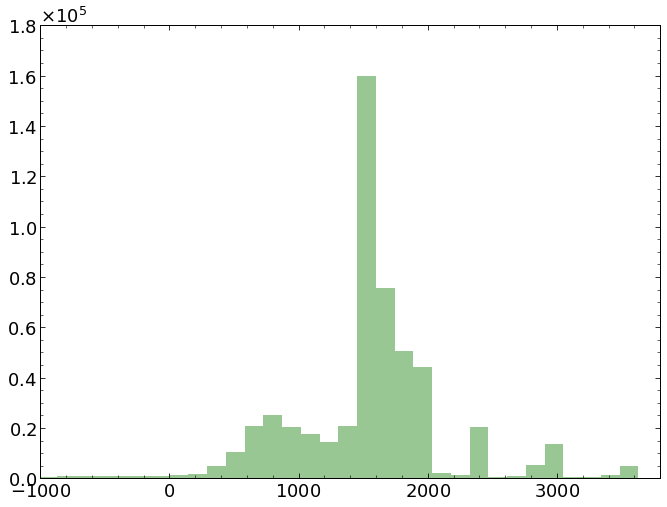

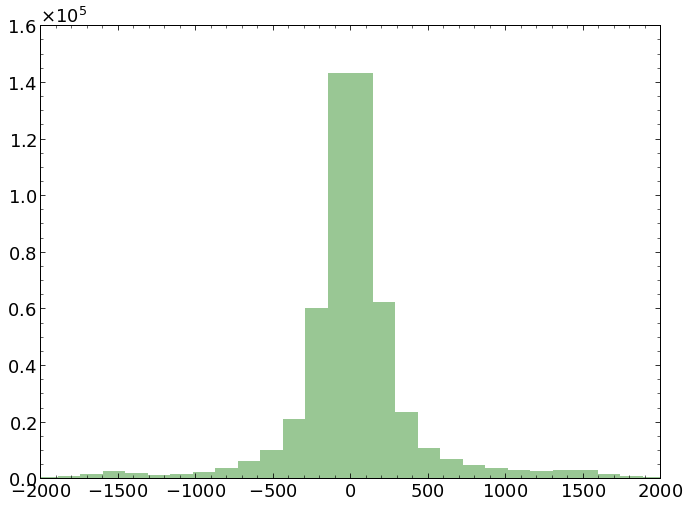

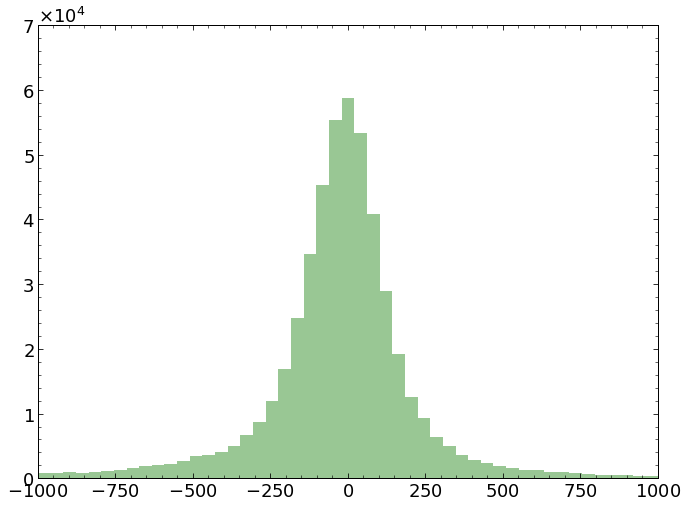

In [22]:
xbins=np.linspace(-1000, 3800, endpoint=True)
plt.hist(X[nz_mask, 1], bins=50)
plt.xlim(np.min(xbins), np.max(xbins))
plt.show()

ybins=np.linspace(-2000, 2000, endpoint=True)
plt.hist(X[nz_mask, 2], bins=50)
plt.xlim(np.min(ybins), np.max(ybins))
plt.show()

zbins = np.linspace(-1000, 1000, 50, endpoint=True)
plt.hist(X[nz_mask, 3], bins=zbins)
plt.xlim(np.min(zbins), np.max(zbins))
plt.show()